---
title: "overfitting and underfitting"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

The previous chapter dealt with the impact of model complexity on the partitioning of the error into bias+variance+noise, and on the bias-variance tradeoff. All the arguments there were based on our ability to repeatedly sample from the population, and to compute the expected values of the error components across these samples.

Most often, we only have one dataset, and we cannot compute these expected values. In this chapter, we will see how the concepts of bias and variance can inform our understanding of the generalization performance of a model, that is, its ability to make accurate predictions on new, unseen data.


As in the previous chapter, we will the following model for the data generating process:

$$
y = f(x) + \epsilon,
$$

where $f(x) = \sin(4\pi x)+3x$ is the "ground truth" function, and $\epsilon \sim \mathcal{N}(0, 0.3^2)$ is the noise.

We generate a population of 10 thousand data points from this model, see how it looks.

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from numpy.polynomial import Chebyshev

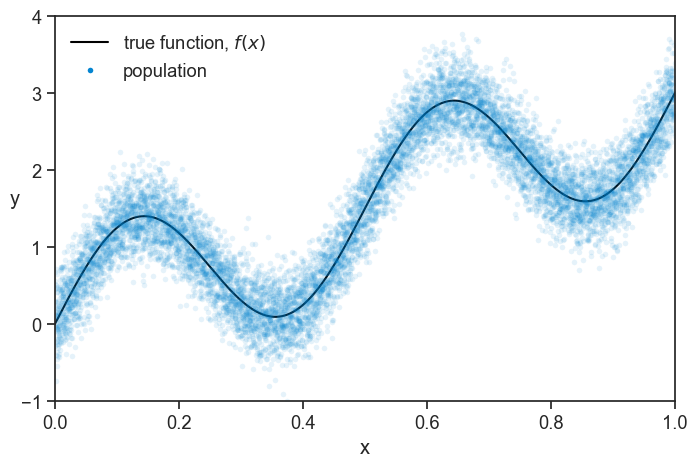

In [2]:
#| code-summary: "true function and population"
np.random.seed(0)
N = 10000
f = lambda x: np.sin(4*np.pi*x) + 3*x
blue = "xkcd:cerulean"
gold = "xkcd:gold"
pink = "xkcd:hot pink"
green = "xkcd:forest"

pop_x = np.linspace(0, 1, N)
noise_pop = np.random.normal(0, 0.3, size=N)
pop_y = f(pop_x) + noise_pop
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(pop_x, f(pop_x), color='black', label=r'true function, $f(x)$')
ax.plot(pop_x, pop_y,
        ls="None", marker='o', markersize=4, alpha=0.1, mfc=blue,
        mec="None",)
ax.plot([-10], [-10], ls="None", marker='o', markersize=4, alpha=1, mfc=blue, mec="None", label="population")
ax.set(xlabel="x",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);
ax.legend(loc='upper left', frameon=False)

We perform a single experiment, where we sample 50 data points from the population. For reasons that will become clear later, we split this sample into two groups, one with 30 data points, and one with 20. See below how the first group, which we call "training set", looks like.

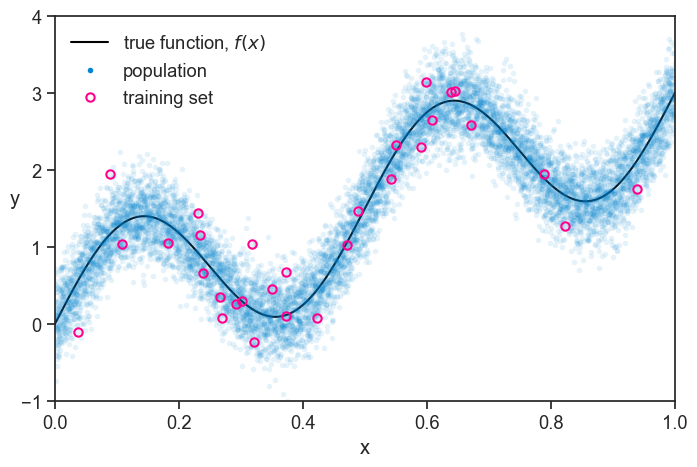

In [3]:
#| code-summary: "population and training set"
np.random.seed(0)
n = 50
idx = np.random.choice(N, size=n, replace=False)
sample_x = pop_x[idx]
sample_y = pop_y[idx]

train_x = sample_x[:30]
train_y = sample_y[:30]
test_x = sample_x[30:]
test_y = sample_y[30:]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(pop_x, f(pop_x),
        color='black', label=r'true function, $f(x)$')
ax.plot(pop_x, pop_y,
        ls="None", marker='o', markersize=4, alpha=0.1, mfc=blue,
        mec="None")
ax.plot([-10], [-10], ls="None", marker='o', markersize=4, alpha=1, mfc=blue, mec="None", label="population")

ax.plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor=pink, 
        markeredgewidth=1.5, clip_on=False, label="training set")
ax.set(xlabel="x",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0)
ax.legend(loc='upper left', frameon=False);

At first glance, the training set looks like a pretty good representation of the population. Of course, we are simulating everything on the computer, so we know the true function and the population. In real life, we only have what we measured, and it looks like this:

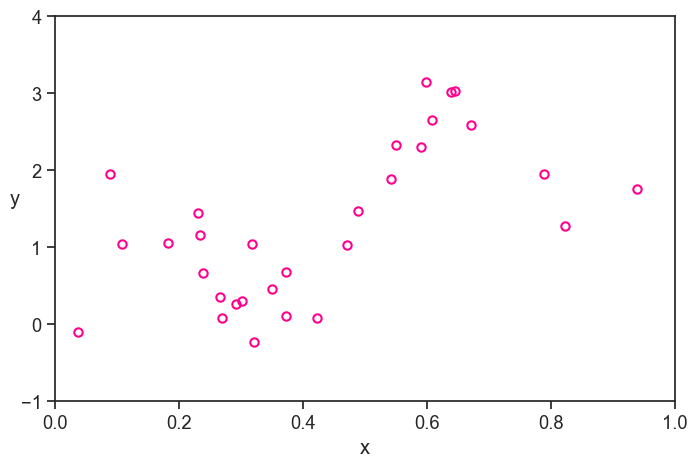

In [4]:
#| code-summary: "just the training set"
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor=pink, 
        markeredgewidth=1.5, clip_on=False)
ax.set(xlabel="x",
        xlim=(pop_x[0], pop_x[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);

Personally, I fill a lot less confident about my ability to model the true function based on this data, without the benefit of the context of the population and the true function.

My job is to find a model that best captures the relationship between $x$ and $y$ in the measured data, in the hope that it will also describe something fundamental about the true function.

As in the previoius chapter, I will focus only on polynomials to model my data. See below four different polynomial fits to the training data, with degrees 2, 5, 10, and 15.

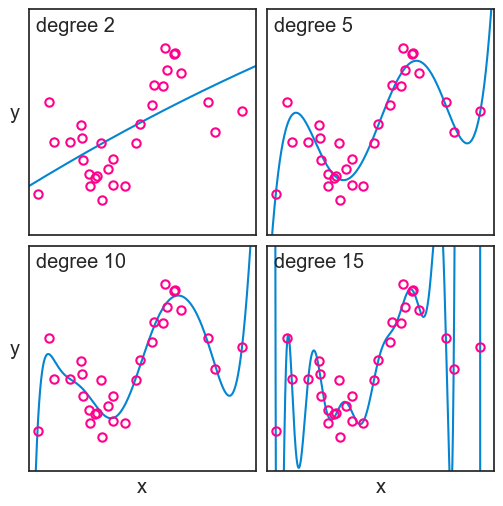

In [5]:
#| code-summary: "plot"
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
degrees = [2, 5, 10, 15]
ax = ax.flatten()
poly_fits = []
# for each degree, use np.polyfit to fit train data
for i, degree in enumerate(degrees):
    coeffs = np.polyfit(train_x, train_y, degree)
    poly = np.poly1d(coeffs)
    poly_fits.append(poly)
    ax[i].plot(pop_x, poly(pop_x), label=f"degree {degree}", color=blue)
    # ax[i].legend(loc='upper left', frameon=False)
    ax[i].plot(train_x, train_y, ls="None", marker='o', markersize=6,
        markerfacecolor='None', markeredgecolor=pink, 
        markeredgewidth=1.5, clip_on=False)
    ax[i].text(0.03, 0.97, f"degree {degree}", transform=ax[i].transAxes,
          horizontalalignment='left', verticalalignment='top',)
    ax[i].set(xticks=[],
              yticks=[],
              xlim=(pop_x[0], pop_x[-1]),
              ylim=(-1, 4))
ax[0].set_ylabel("y", rotation=0, labelpad=10)
ax[2].set(xlabel="x",)
ax[2].set_ylabel("y", rotation=0, labelpad=10)
ax[3].set(xlabel="x",);

We can't determine neither the bias nor the variance of these models, because we only have one dataset. But from what we learned, we can surmise that the degree 2 model, not being flexible enought, is likely to have a high bias, that is, it probably differs from the true function in a systematic way. The degree 15 polynomial, on the other hand, is very flexible, but it is likely to have a high variance, that is, it is sensitive to the particularities of the training data.

Now it is time to evaluate the performace of each model. We will start with the wrong way, which is very educational, and then we will see the right way.

## evaluating performance the wrong way

Let's call the error of a model the difference between the predicted values $\hat{f}$ and the true values $y$ that we obeserved:

$$
\text{error} = \hat{f}(x) - y.
$$

We can compute this error for each data point in the training set, and then we can compute the mean squared error (MSE) across all data points:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (\hat{f}(x_i) - y_i)^2.
$$

Let's see how the MSE changes as a function of the degree of the polynomial.

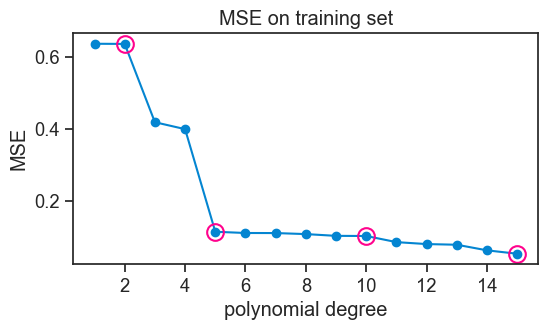

In [6]:
#| code-summary: "plot MSE for training set"
fig, ax = plt.subplots(figsize=(6, 3))
d_list = np.arange(1, 16)
MSE = []
trained_polys = []
for i, degree in enumerate(d_list):
    coeffs = np.polyfit(train_x, train_y, degree)
    poly = np.poly1d(coeffs)
    trained_polys.append(poly)
    MSE.append(np.mean((poly(train_x) - train_y)**2))
MSE = np.array(MSE)
ax.plot(d_list, MSE, marker='o', color=blue)
idx = np.array(degrees)-1
ax.plot(degrees, MSE[idx], ls="None", marker='o', mfc="None", mec=pink, markersize=12, markeredgewidth=1.5)
# ax.set_yscale('log')
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       title='MSE on training set',);


Note that we marked the polynomial fits for degrees 2, 5, 10, and 15 with pink circles.

Not surprisingly, the higher the polynomial degree, the lower the MSE on the training set. It couldn't be otherwise. Think about it. A degree 4 polynomial is a particular case of a degree 5 polynomial, where the parameter for $x^5$ is zero. So the degree 5 polynomial can always fit the training data at least as well as the degree 4 polynomial, and it can do better if it finds a non-zero parameter for $x^5$. The same logic applies to all higher degree polynomials. So the MSE on the training set will always decrease as we increase the degree of the polynomial. In fact, with 30 data points in our training set, a degree 29 polynomial can fit the training data perfectly, and achieve an MSE of zero.

Take a look again at the fit for the degree 15 polynomial. It passes very close to most points in the training set, but at the cost of wild fluctuations. Having the benefit of the population and the true function, we can see that these fluctuations are not capturing any fundamental aspect of the true function, but rather they are fitting the particularities of the training data. This is called **overfitting**. Should we ever get a second dataset from the same population, we would see that the degree 15 polynomial performs very poorly on it.

The degree 2 polynomial, on the other hand, is not flexible enough to capture the relationship between $x$ and $y$ in the training data. It is systematically off from the true function, and it is not capturing some fundamental aspect of the relationship between $x$ and $y$. This is called **underfitting**. Should we get a second dataset from the same population, we would see that the degree 2 polynomial performs poorly on it as well.

## the right way

You must have surely guessed by now that the right way to evaluate the performance of a model is to use the second group of data points that we set aside at the beginning, which we call "test set".

Let's compute the MSE on the test set for each model, and see how it changes as a function of the degree of the polynomial.

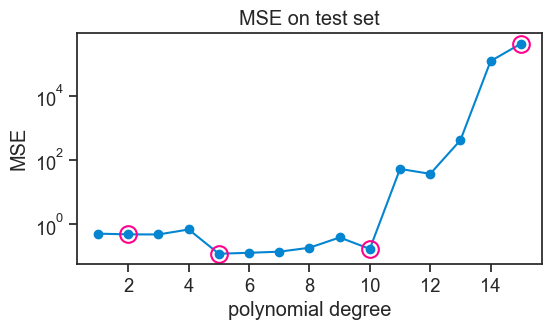

In [7]:
#| code-summary: "plot MSE for test set"
fig, ax = plt.subplots(figsize=(6, 3))
MSE_test = []
for i, degree in enumerate(d_list):
    MSE_test.append(np.mean((trained_polys[i](test_x) - test_y)**2))
MSE_test = np.array(MSE_test)
ax.plot(d_list, MSE_test, marker='o', color=blue)
idx = np.array(degrees)-1
ax.plot(degrees, MSE_test[idx], ls="None", marker='o', mfc="None", mec=pink, markersize=12, markeredgewidth=1.5)
ax.set_yscale('log')
ax.set(xlabel='polynomial degree',
       ylabel='MSE',
       title='MSE on test set'
       # ylim=(0, 1)
       );


When confronted with unseed data, the higher-order polynomials now perform abysmally. Their MSE is so high that I had to use a logarithmic scale on the y-axis.

The performace of models of increasing complexity now shows a typical U-shape. Initially, the MSE on the test set decreases, because the model is becoming more flexible, and it can capture better the underlying relationship between $x$ and $y$. At this stage we are getting away from underfitting. However, after a certain point, increasing the degree of the polynomial leads to overfitting, where the model starts to capture noise in the training data rather than the true underlying relationship. This results in an increase in MSE on the test set.

In this example, all polynomials from degree 5 to 10 perform approximately equally well, meaning that the generalize equally well to new data.

## concluding remarks

We will deal with the split of our dataset into training and test sets in more detail in the next chapter. For now, the main takeaway is that when we evaluated our models against each of these sets, we were asking different questions.

* **How well does this model reproduce the data I already showed it?** This is what the first evaluation, based on the training set, was asking.
* **How well will this model perform on new data drawn from the same population?** This is what the second evaluation, based on the test set, was asking.

The second question is what we really care about. This is the fundamental reason why splitting our dataset is not a waste of data.


<!-- Core question

Where does prediction error come from?

Main goal

Make bias and variance visible, not operational.

Topics to cover

synthetic data from a known function

repeated datasets (or resampling)

polynomial fits of varying degree

averaging predictions at fixed x

visualization of:

mean prediction (bias)

spread of predictions (variance)

conceptual error decomposition (no heavy math) -->